In [1]:
# The API link
link = "https://data.cms.gov/resource/ehrv-m9r6.json"

# The app token
key = "oBbcgRhXZS4dqtTJVyz6zQujv"

# Code snippet for data retrieval using python, as provided by the API information page
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
warnings.filterwarnings('ignore')

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cms.gov", key)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cms.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ehrv-m9r6", limit=163065)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Checking the head of the data frame
results_df.head()

,average_covered_charges,average_medicare_payments,average_medicare_payments_2,drg_definition,hospital_referral_region_description,provider_city,provider_id,provider_name,provider_state,provider_street_address,provider_zip_code,total_discharges
0,32963.07,5777.24,4763.73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Dothan,DOTHAN,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,1108 ROSS CLARK CIRCLE,36301,91
1,15131.85,5787.57,4976.71,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,BOAZ,10005,MARSHALL MEDICAL CENTER SOUTH,AL,2505 U S HIGHWAY 431 NORTH,35957,14
2,37560.37,5434.95,4453.79,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,FLORENCE,10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,205 MARENGO STREET,35631,24
3,13998.28,5417.56,4129.16,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,BIRMINGHAM,10011,ST VINCENT'S EAST,AL,50 MEDICAL PARK EAST DRIVE,35235,25
4,31633.27,5658.33,4851.44,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL - Birmingham,ALABASTER,10016,SHELBY BAPTIST MEDICAL CENTER,AL,1000 FIRST STREET NORTH,35007,18


In [2]:
# Gathering columns needed for analysis
Q2stateGB = results_df[["provider_state","drg_definition","average_covered_charges"]]
Q2stateGB.head()

,provider_state,drg_definition,average_covered_charges
0,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,32963.07
1,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,15131.85
2,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,37560.37
3,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,13998.28
4,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,31633.27


In [3]:
# Groupby "provider_state" and doing a "drg_definition" count
Q2drg_definition = Q2stateGB.groupby("provider_state").drg_definition.count()
Q2drg_definition = pd.DataFrame(Q2drg_definition).reset_index()
Q2drg_definition.head()

,provider_state,drg_definition
0,AK,231
1,AL,3635
2,AR,2067
3,AZ,2851
4,CA,13064


In [4]:
# Converting "average_covered_charges" column to float
Q2stateGB["average_covered_charges"] = Q2stateGB["average_covered_charges"].astype(float)

# Groupby "provider_state" and finding the mean for "average_covered_charges"
Q2average_covered_charges = Q2stateGB.groupby("provider_state").average_covered_charges.mean()
Q2average_covered_charges = pd.DataFrame(Q2average_covered_charges).reset_index()
Q2average_covered_charges.head()

,provider_state,average_covered_charges
0,AK,40348.743333
1,AL,31316.462074
2,AR,26174.526246
3,AZ,41200.063020
4,CA,67508.616536


In [5]:
# Merging the two dataframes
Q2DF = pd.merge(Q2drg_definition, Q2average_covered_charges, on = "provider_state", how="outer")

# Creating a new column to find the avg cost per drg
Q2DF["avg per drg"] = Q2DF["average_covered_charges"]/Q2DF["drg_definition"]
Q2DF.head()

,provider_state,drg_definition,average_covered_charges,avg per drg
0,AK,231,40348.743333,174.669885
1,AL,3635,31316.462074,8.615258
2,AR,2067,26174.526246,12.663051
3,AZ,2851,41200.063020,14.451092
4,CA,13064,67508.616536,5.167530


In [6]:
# Renaming the column index
Q2DF = Q2DF.rename(columns={"provider_state":"State","drg_definition":"DRG Count",
                           "average_covered_charges":"Average Cost","avg per drg":"Cost Per DRG"})

# Formatting float columns
pd.options.display.float_format = '${:,.2f}'.format
Q2DF.head()

,State,DRG Count,Average Cost,Cost Per DRG
0,AK,231,"$40,348.74",$174.67
1,AL,3635,"$31,316.46",$8.62
2,AR,2067,"$26,174.53",$12.66
3,AZ,2851,"$41,200.06",$14.45
4,CA,13064,"$67,508.62",$5.17


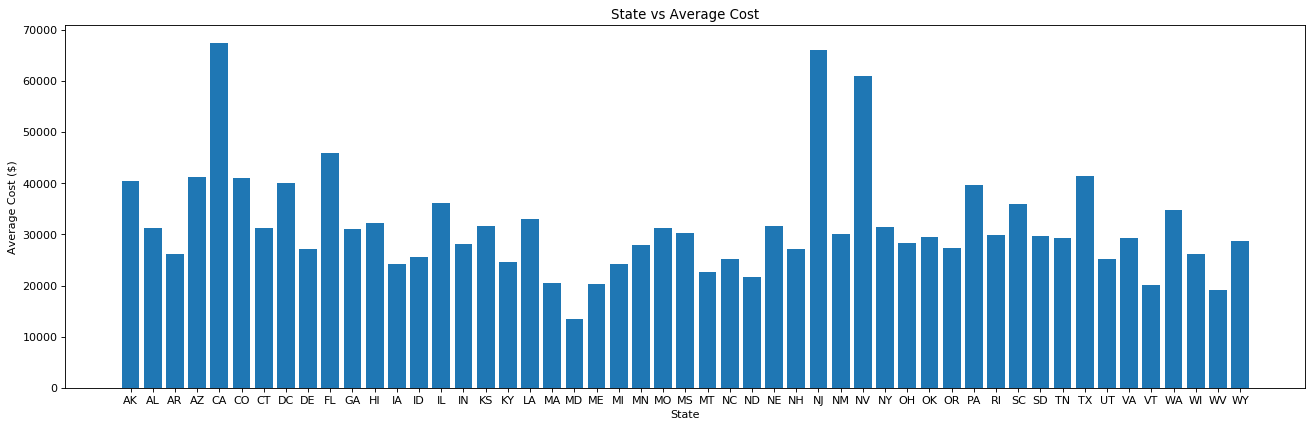

In [7]:
# Import plot modules and defining plot settings
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

# Defining x and y values for plot
x1 = Q2DF["State"]
y1 = Q2DF["Average Cost"]

# Bar plot. Where x is the State and y is the average cost
plt.bar(x1, y1)
plt.title("State vs Average Cost")
plt.xlabel("State")
plt.ylabel("Average Cost ($)")
plt.show()

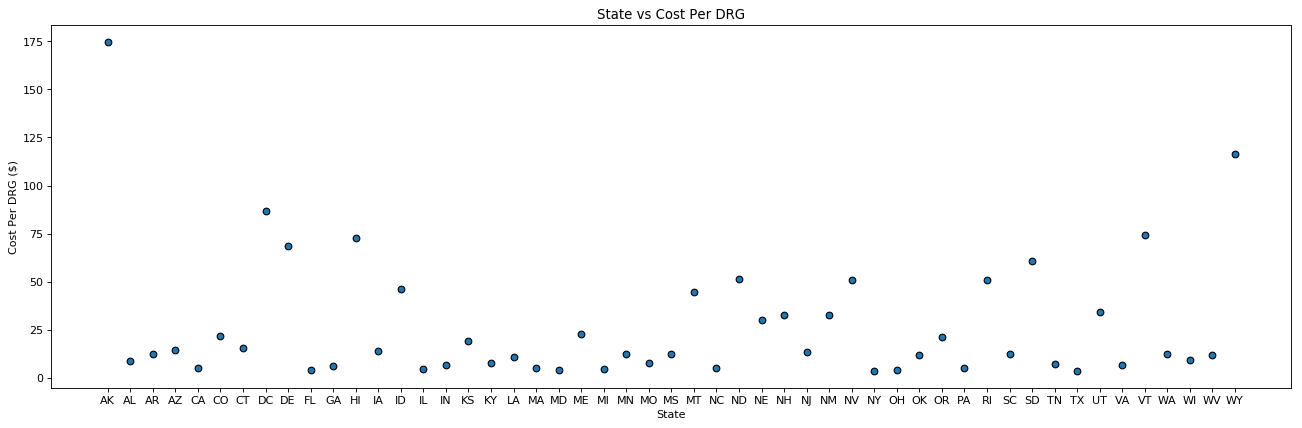

In [8]:
# Defining plot settings
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

# Defining x and y values for plot
x2 = Q2DF["State"]
y2 = Q2DF["Cost Per DRG"]

# Scatter plot. Where x is the State and y is the Cost per DRG
plt.scatter(x2, y2, edgecolors="black")
plt.title("State vs Cost Per DRG")
plt.xlabel("State")
plt.ylabel("Cost Per DRG ($)")
plt.show()